# Union Simulation

What do we actually want to do here? We want to understand how the network and liqudity is consumed by the network.
We need to loop a bunch of times, select a random agents, select a random action and select random inputs for said action. 

Things we want to measure
- total liqidity (pool balance - total borrowed)
- total members (with at least "effective_number" of vouches)
- total_borrowed
- total_repaid

In [178]:
%matplotlib inline  

import random
import matplotlib.pyplot as plt

agents = 100
effective_number = 1

borrow_probability = 100
vouch_probability = 100
repay_probability = 100
stake_probability = 100

max_stake = 100
max_vouch = 1000
max_borrow = 1000 
min_borrow = 100
max_repay = 1000
min_repay = 500

In [179]:
action_names = ["borrow", "repay", "stake", "vouch"]

actions = {
    "borrow": {
        "probability": borrow_probability,
        "min": min_borrow,
        "max": max_borrow,
    },
    "repay": {
        "probability": repay_probability,
        "min": min_repay,
        "max": max_repay,
    },
    "stake": {
        "probability": stake_probability,
        "max": max_stake
    },
    "vouch": {
        "probability": vouch_probability,
        "max": max_vouch
    }
}

# Simulation

In [201]:
simulation = []
connections = []

stakes = [0 for _ in range(agents)]
vouches = [{} for _ in range(agents)]
borrows = [{} for _ in range(agents)]
repays = [{} for _ in range(agents)]

snapshots_per_epoch = []

def get_total_borrowed():
    return sum(item["amount"] if item["action"] == "borrow" else 0 for item in simulation)

def get_total_repaid():
    return sum(item["amount"] if item["action"] == "repay" else 0 for item in simulation)

def get_total_vouches(agent):
    n_vouches = 0
    for i, vouch in enumerate(vouches):
        if "borrower" in vouch and vouch["borrower"] == agent:
            n_vouches+=1
    return n_vouches

def get_total_members():
    sum(int(get_total_vouches(agent)) for agent in range(agents))

def get_total_staked():
    return sum(item["amount"] if item["action"] == "stake" else 0 for item in simulation)

def get_total_liquidity():
    return get_total_staked() - (get_total_borrowed() - get_total_repaid())

def get_credit_limit(borrower_agent):
    credit_limit = 0
    for agent, vouch in enumerate(vouches):
        if borrower_agent in vouch:
            staked = stakes[agent]
            credit_limit += min(staked, vouch[borrower_agent])
    return credit_limit

def get_outstanding(borrower, staker):
    # get borrowed
    n_borrowed = borrows[staker][borrower] if borrower in borrows[staker] else 0
    # get repaid
    n_repaid = repays[staker][borrower] if borrower in repays[staker] else 0
    
    assert(n_borrowed - n_repaid >= 0)
    return n_borrowed - n_repaid

def get_total_outstanding(borrower):
    # get borrowed
    n_borrowed = 0
    for borrowers in borrows:
        if borrower in borrowers:
            n_borrowed += borrowers[borrower]
            
    # get repaid
    n_repaid = 0
    for repayers in repays:
        if borrower in repayers:
            n_repaid += repayers[borrower]
    
    assert(n_borrowed - n_repaid >= 0)
    return n_borrowed - n_repaid
    

for i in range(5000):
    action_name = action_names[random.randint(0,3)]
    action = actions[action_name]
    
    do_action = random.randint(0,100) < action["probability"]
    
    staker = random.randint(0, agents - 1)
    borrower = random.randint(0, agents - 1)
    amount = random.randint(0, action["max"])
    
    if do_action: 
        if action_name == "vouch":
            connections.append({ "staker": staker, "borrower": borrower })
            if borrower not in vouches[staker]:
                vouches[staker][borrower] = amount
        elif action_name == "stake":
            stakes[staker] += amount 
        elif action_name == "borrow":
            credit_limit = get_credit_limit(borrower)
            outstanding = get_total_outstanding(borrower)
            amount = min([amount, credit_limit - outstanding])
            borrows[staker][borrower] = amount           
        elif action_name == "repay":
            outstanding = get_outstanding(borrower, staker)
            amount = min([outstanding, amount])
            repays[staker][borrower] = amount
        
        simulation.append({
            "action": action_name,
            "amount": amount,
            "total_borrowed": get_total_borrowed(),
            "total_repaid": get_total_repaid(),
            "total_members": get_total_members(),
            "total_liquidity": get_total_liquidity(),
        })

AssertionError: 

## Graphs

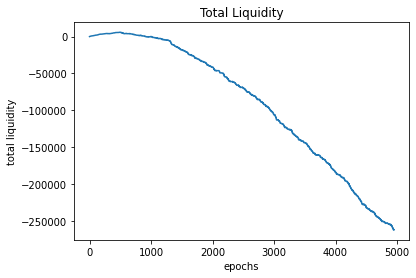

In [198]:
import matplotlib.pyplot as plt

y_total_liquidity = [item["total_liquidity"] for item in simulation]
x_epochs = [i for i, _ in enumerate(simulation)]

plt.plot(x_epochs, y_total_liquidity)
plt.xlabel("epochs")
plt.ylabel("total liquidity")
plt.title("Total Liquidity")
plt.show()

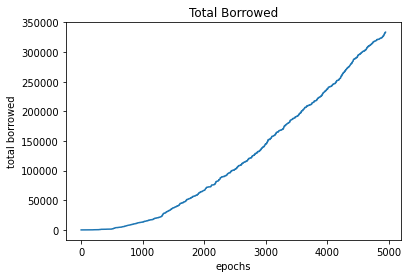

In [199]:
y_total_liquidity = [item["total_borrowed"] for item in simulation]
x_epochs = [i for i, _ in enumerate(simulation)]

plt.plot(x_epochs, y_total_liquidity)
plt.xlabel("epochs")
plt.ylabel("total borrowed")
plt.title("Total Borrowed")
plt.show()

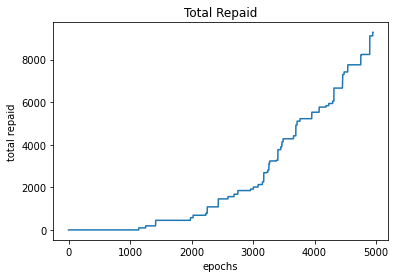

In [200]:
y_total_liquidity = [item["total_repaid"] for item in simulation]
x_epochs = [i for i, _ in enumerate(simulation)]

plt.plot(x_epochs, y_total_liquidity)
plt.xlabel("epochs")
plt.ylabel("total repaid")
plt.title("Total Repaid")
plt.show()